Task 2
======

Import packages
---------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import vstack

from sklearn.naive_bayes import MultinomialNB

EM functions
------------

In [20]:
def calculate_unlabeled_loss(class_prob, feature_prob, X_train_unlabelled):

    n = X_train_unlabelled.shape[0]
    
    p_xi_cj = np.sum(feature_prob, axis = 1, keepdims = True)
    class_prob = class_prob.reshape(class_prob.shape[0],1)

    sum_loss = class_prob + p_xi_cj
    sum_for_all_classes = np.sum(sum_loss, axis = 0, keepdims = True)
    sum_for_all_classes = sum_for_all_classes[0]

    total_loss = n * sum_for_all_classes

    return total_loss

def calculate_labelled_loss(class_prob, feature_prob, X_train_labelled, y_train_labelled):
    n_labelled = X_train_labelled.shape[0]
    loss = 0
    sum_of_feature_log_probs = np.sum(feature_prob, axis = 1, keepdims = True)
    for i in range(n_labelled):
        c_index = y_train_labelled[i]
        prob_for_c = class_prob[c_index]
        feature_value_for_c = sum_of_feature_log_probs[c_index]
        loss += (prob_for_c + feature_value_for_c)
    return loss

def perform_EM(X_train_labelled, y_train_labelled, X_train_unlabelled):
    
    losses = list()

    multinomial_clf = MultinomialNB(alpha = 0.01)
    multinomial_clf.fit(X_train_labelled, y_train_labelled)
    
    class_prob = multinomial_clf.class_log_prior_
    feature_prob = multinomial_clf.feature_log_prob_
    
    old_loss = 0
    loss = -1 * (calculate_unlabeled_loss(class_prob, feature_prob, X_train_unlabelled)
              + calculate_labelled_loss(class_prob, feature_prob, X_train_labelled, y_train_labelled))
    
    losses.append(loss)

    diff = loss - old_loss
    
    threshold = np.exp(-10)
    
    while(abs(diff) > threshold):
        old_loss = loss
        
        #E-step
        y_train_unlabelled_predicted = multinomial_clf.predict(X_train_unlabelled)

        #Combining the data
        X_train_total = vstack([X_train_labelled, X_train_unlabelled])
        y_train_total = np.concatenate((y_train_labelled, y_train_unlabelled_predicted), axis = 0)

        #M-step
        multinomial_clf.fit(X_train_total, y_train_total)
        
        class_prob = multinomial_clf.class_log_prior_
        feature_prob = multinomial_clf.feature_log_prob_
        
        loss = -1 * (calculate_unlabeled_loss(class_prob, feature_prob, X_train_unlabelled)
                  + calculate_labelled_loss(class_prob, feature_prob, X_train_labelled, y_train_labelled))
        
        losses.append(loss)

        diff = loss - old_loss

    return multinomial_clf, losses



NB functions
------------

In [3]:
def perform_naive_bayes(X_train, y_train, X_test):

    clf = MultinomialNB(alpha = 0.01)
    clf = clf.fit(X_train, y_train)

    y_test_predicted = clf.predict(X_test)

    return y_test_predicted

Import data and apply TF-IDF
----------------------------

In [4]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)

In [5]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(twenty_train.data)
print(X_train.shape)

y_train = twenty_train.target
print(y_train.shape)

(11314, 130107)
(11314,)


In [6]:
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)
X_test = tfidf_vectorizer.transform(twenty_test.data)
print(X_test.shape)

y_test_expected = twenty_test.target
print(y_test_expected.shape)

(7532, 130107)
(7532,)


Naive Bayes Test
----------------

In [7]:
y_test_predicted_nb = perform_naive_bayes(X_train, y_train, X_test)

print("NB accuracy: ", np.sum(y_test_predicted_nb == y_test_expected) / len(y_test_predicted_nb))

NB accuracy:  0.8352363250132767


Expectation Maximization Test
-----------------------------

In [26]:
# split training data into partially labelled and partially unlabelled for EM
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train_labelled, X_train_unlabelled, y_train_labelled, _ = train_test_split(X_train, y_train, train_size = 0.20)

print(X_train_labelled.shape)
print(X_train_unlabelled.shape)
print(y_train_labelled.shape)

(2262, 130107)
(9052, 130107)
(2262,)


In [27]:
em_trained_clf, losses = perform_EM(X_train_labelled, y_train_labelled, X_train_unlabelled)

In [28]:
y_test_predicted_em = em_trained_clf.predict(X_test)

print("EM accuracy: ", np.sum(y_test_predicted_em == y_test_expected) / len(y_test_predicted_em))

EM accuracy:  0.7818640467339352


Something wrong here
--------------------

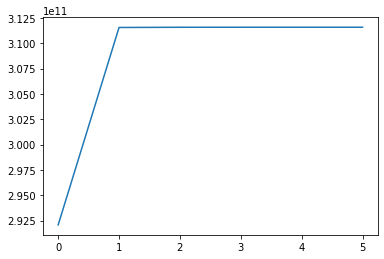

In [29]:
plt.plot(losses)

NB and EM comparative test
--------------------------

NB accuracy: 0.6795007966011684 EM accuracy: 0.7265002655337228
NB accuracy: 0.7465480616038237 EM accuracy: 0.7626128518321826
NB accuracy: 0.7777482740308019 EM accuracy: 0.7910249601699416
NB accuracy: 0.7999203398831651 EM accuracy: 0.8061603823685608
NB accuracy: 0.8080191184280403 EM accuracy: 0.8108072225172597
NB accuracy: 0.8203664365374402 EM accuracy: 0.8208975039830059
NB accuracy: 0.8224907063197026 EM accuracy: 0.8244822092405736
NB accuracy: 0.8252788104089219 EM accuracy: 0.8292618162506639
NB accuracy: 0.8345724907063197 EM accuracy: 0.832979288369623


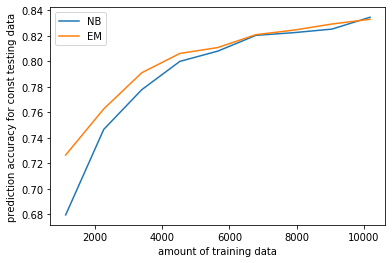

In [25]:
step = 10
percentages = range(step, 100, step)
train_sizes = list()
nb_accuracies = list()
em_accuracies = list()

for percentage in percentages:

    # EM
    X_train_labelled_loop, X_train_unlabelled_loop, y_train_labelled_loop, _ = train_test_split(X_train, y_train, train_size = percentage / 100)
    em_trained_clf, _ = perform_EM(X_train_labelled_loop, y_train_labelled_loop, X_train_unlabelled_loop)
    y_test_predicted_em_loop = em_trained_clf.predict(X_test)
 
    em_accuracy = np.sum(y_test_predicted_em_loop == y_test_expected) / len(y_test_predicted_em_loop)

    # NB
    y_test_predicted_nb_loop = perform_naive_bayes(X_train_labelled_loop, y_train_labelled_loop, X_test)

    nb_accuracy = np.sum(y_test_predicted_nb_loop == y_test_expected) / len(y_test_predicted_nb_loop)

    print("NB accuracy:", nb_accuracy, "EM accuracy:", em_accuracy)

    train_sizes.append(y_train_labelled_loop.size)
    nb_accuracies.append(nb_accuracy)
    em_accuracies.append(em_accuracy)

plt.plot(train_sizes, nb_accuracies, label='NB')
plt.plot(train_sizes, em_accuracies, label='EM')
plt.xlabel("amount of training data")
plt.ylabel("prediction accuracy for const testing data")
plt.legend()